<h1>Import Necessary Libraries</h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
from PIL import Image
from tqdm import tqdm

import os 
import time
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU")
    except RuntimeError as e:
        print(e)

Using GPU


In [3]:
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<h1>Preprocessing</h1>

In [4]:
data_path = 'utkcropped/'

In [5]:
# load the dataset from the directory using a batch size of 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(128, 128),
    shuffle=True
)

Found 23709 files belonging to 1 classes.


<h2>Visualizing the dataset</h2>

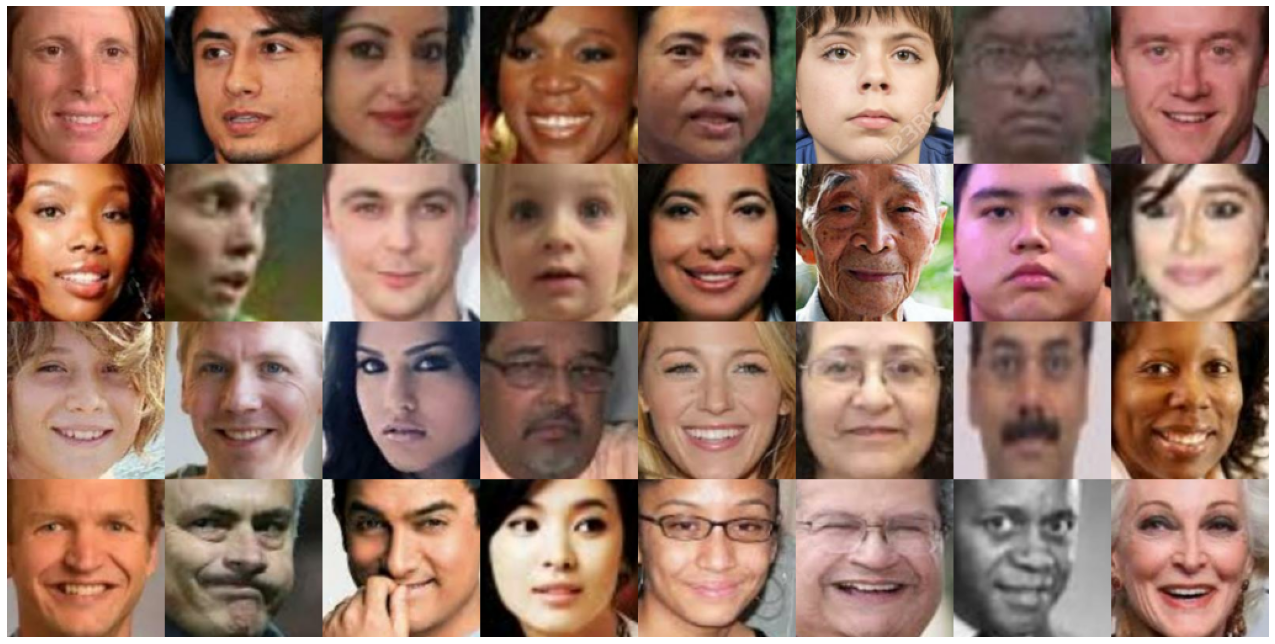

In [6]:
def plot_batch(batch, rows, cols):
    
    index = 0
    face_size = batch.shape[1]
    width = face_size * cols
    height = face_size * rows
    figure = np.zeros(shape=(height, width, 3))
    
    for row in range(rows):
        for col in range(cols):
            figure[
                row * face_size: (row + 1) * face_size,
                col * face_size: (col + 1) * face_size,
            ] = batch[index]
            
            index += 1
    
    plt.figure(figsize=(2.9 * cols, 2.9 * rows))
    plt.imshow(figure)
    plt.axis("off")
    

batch_image = next(iter(train_ds.take(1)))
batch_image = batch_image.numpy()/255

plot_batch(batch_image, 4, 8)

In [7]:
train_ds = train_ds.map(lambda x: (x / 255.0)) # convert the dataset to a range of [0,1]

<h1>Define Model</h1>

In [4]:
latent_dim = 2048
intitializer = tf.keras.initializers.he_normal()

### Define encoder

In [5]:
encoder_inputs = tf.keras.layers.Input(shape=(128, 128, 3),name="encoder_input")
                      
x = tf.keras.layers.InputLayer(input_shape=(128,128,3))(encoder_inputs)

x = tf.keras.layers.Conv2D(32,3,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #64,64,32

x = tf.keras.layers.Conv2D(64,3,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #32,32,64
 
x = tf.keras.layers.Conv2D(128,5,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #16,16,128

x = tf.keras.layers.Conv2D(128,5,strides=(2,2),padding='same',kernel_initializer=intitializer)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #8,8,128
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(8*8*128,activation='relu',kernel_initializer=intitializer)(x)
z_mean = tf.keras.layers.Dense(latent_dim,activation='linear',kernel_initializer=intitializer)(x) # mean
z_log_var = tf.keras.layers.Dense(latent_dim,activation='linear',kernel_initializer=intitializer)(x) # log(variance)

encoder = tf.keras.models.Model(encoder_inputs,[z_mean,z_log_var])
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            multiple             0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[1][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
_______________________________________________________________________________________

### Define decoder

In [6]:
decoder_input = tf.keras.layers.Input(shape=(latent_dim,), name="decoder_input")

x = tf.keras.layers.Dense(units=8*8*128, activation='relu',kernel_initializer=intitializer)(decoder_input)
x = tf.keras.layers.Reshape(target_shape=(8,8,128))(x)


x = tf.keras.layers.Conv2DTranspose(128,5,strides=2,padding='same',kernel_initializer=intitializer)(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) #16,16,128

x = tf.keras.layers.Conv2DTranspose(64,5,strides=2,padding='same',kernel_initializer=intitializer)(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 32,32,64

x = tf.keras.layers.Conv2DTranspose(32,3,strides=2,padding='same',kernel_initializer=intitializer)(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x) # 64,64,32


decoder_img = tf.keras.layers.Conv2DTranspose(3,3,strides=2,padding='same',activation='sigmoid',kernel_initializer=intitializer)(x) # 128,128,3

decoder = tf.keras.models.Model(decoder_input, decoder_img, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              16785408  
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       409728    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        204864    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)      

# Define the main Model

Since the variational autoencoder is different from standard feed forward CNN's, we can overwrite the training step by
subclassing the keras `Model` class

In [7]:
class CVAE(keras.Model):

    def __init__(self,latent_dim,encoder,decoder,**kwargs):
        super(CVAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    
    def sampling(self,z_mean,z_log_variance):
        latent_shape = (tf.shape(z_mean)[0],tf.shape(z_mean)[1])
        eps = tf.random.normal(shape=latent_shape)
        return z_mean + tf.exp(0.5*z_log_variance)*eps

    @tf.function
    def train_step(self,data):

        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mean, logvar = encoder(data)
            z = self.sampling(mean,logvar)
            x_logit = self.decoder(z)
      
            reconstruction_loss = tf.reduce_mean(keras.losses.MSE(data, x_logit))
            reconstruction_loss*= 128*128

            KL_div_loss = tf.math.reduce_mean(-0.5*tf.math.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar),axis=1))

            loss = reconstruction_loss + KL_div_loss

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
              "total loss": loss,
              "reconstruction loss": reconstruction_loss,
              "kl divergence loss": KL_div_loss,
            }


In [11]:
class CheckpointCallback(keras.callbacks.Callback):
    def __init__(self):
        super(keras.callbacks.Callback, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        self.model.encoder.save_weights("Weights/encoder_weights.h5")
        self.model.decoder.save_weights("Weights/decoder_weights.h5")
        

In [277]:
with tf.device('/GPU:0'):
    cvae = CVAE(latent_dim,encoder,decoder)
    
    #cvae.encoder.load_weights('Weights/encoder_weights.h5')
    #cvae.decoder.load_weights('Weights/decoder_weights.h5')
    # Uncomment above two lines in case you are continuing training from saved weights
    
    cvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    history = cvae.fit(train_ds, epochs=100, batch_size=128)

Epoch 1/100
186/186 [==============================] - 39s 207ms/step - total loss: 171.4961 - reconstruction loss: 117.1262 - kl divergence loss: 54.3698
Epoch 2/100
186/186 [==============================] - 38s 207ms/step - total loss: 171.4316 - reconstruction loss: 117.0405 - kl divergence loss: 54.3911
Epoch 3/100
186/186 [==============================] - 39s 207ms/step - total loss: 171.3535 - reconstruction loss: 116.9813 - kl divergence loss: 54.3722
Epoch 4/100
186/186 [==============================] - 39s 207ms/step - total loss: 171.0281 - reconstruction loss: 116.7446 - kl divergence loss: 54.2835
Epoch 5/100
186/186 [==============================] - 38s 206ms/step - total loss: 170.7847 - reconstruction loss: 116.4819 - kl divergence loss: 54.3029
Epoch 6/100
186/186 [==============================] - 39s 207ms/step - total loss: 170.9763 - reconstruction loss: 116.6541 - kl divergence loss: 54.3222
Epoch 7/100
186/186 [==============================] - 39s 208ms/step 

In [313]:
cvae.encoder.save_weights("Weights/encoder_weights_manual.h5")
cvae.decoder.save_weights("Weights/decoder_weights_manual.h5")

# Generate random faces

In [8]:
cvae = CVAE(latent_dim,encoder,decoder)
cvae.encoder.load_weights("Weights/encoder_weights.h5")
cvae.decoder.load_weights("Weights/decoder_weights.h5")

In [9]:
def generate_faces():
    noise = tf.keras.backend.random_normal(shape=(64,latent_dim))
    generated_images = cvae.decoder.predict(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        plt.imshow((generated_images[i,:,:,:]))
        plt.axis("off")
    plt.show()

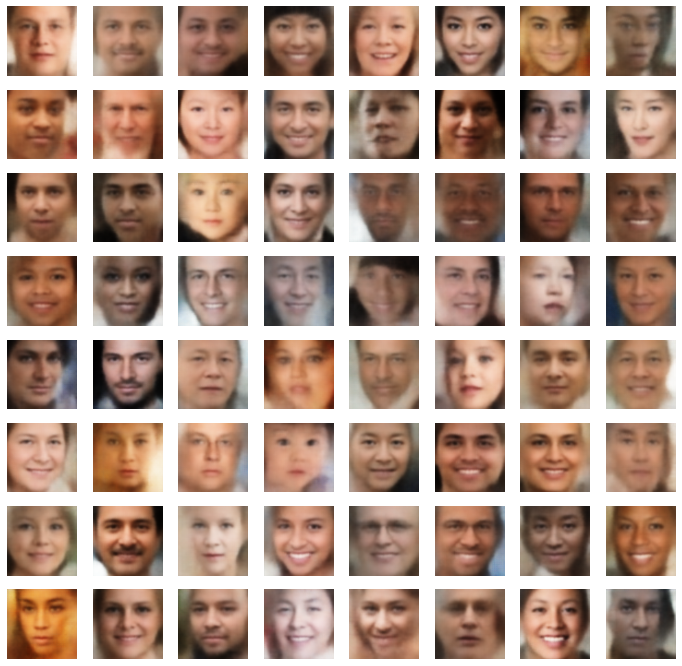

In [13]:
generate_faces()